In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
from vgg16_avg import VGG16_Avg
import keras.backend as K
import keras
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
import matplotlib.pyplot as plt
import scipy

Using TensorFlow backend.


In [2]:
img = Image.open('/run/media/backman/yay/dogbreedKeras/train/beagle/8fb070664c0597ae883da9195c281a66.jpg')

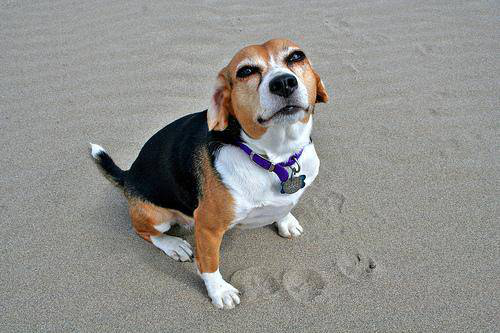

In [3]:
img

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

In [5]:
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [6]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [8]:
shp

(1, 333, 500, 3)

In [9]:
model = VGG16_Avg(include_top=False)

/home/backman/mlSandbox/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/backman/mlSandbox/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/backman/mlSandbox/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/backman/mlSandbox/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  

In [10]:
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [11]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [12]:
loss = K.sum(metrics.mse(layer, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [13]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'/run/media/backman/yay/styleResults/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

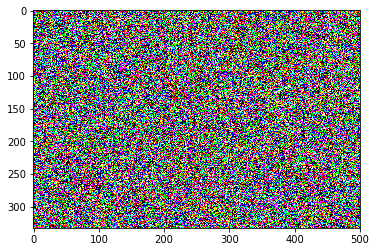

In [14]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [15]:
iterations=10

In [16]:
x = solve_image(evaluator, iterations, x)

Current loss value: 36268.6953125
Current loss value: 10819.2988281
Current loss value: 5664.61230469
Current loss value: 3806.90087891
Current loss value: 2891.86328125
Current loss value: 2307.78271484
Current loss value: 1943.59399414
Current loss value: 1664.42004395
Current loss value: 1480.953125
Current loss value: 1345.50585938


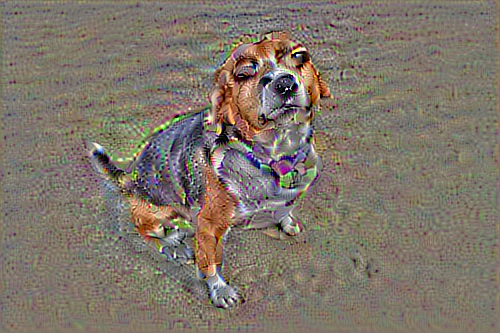

In [17]:
Image.open('/run/media/backman/yay/styleResults/res_at_iteration_9.png')

In [18]:
style = Image.open('/run/media/backman/yay/styleResults/style3.jpg')

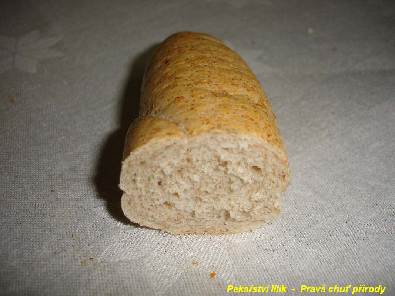

In [19]:
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

In [20]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape
shp

(1, 296, 395, 3)

In [21]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

/home/backman/mlSandbox/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/backman/mlSandbox/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/backman/mlSandbox/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/backman/mlSandbox/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  

In [22]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [23]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [24]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [25]:
def style_loss(x, targ): return K.sum(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [26]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [27]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

In [28]:
iterations=10
x = rand_img(shp)

In [29]:
x = solve_image(evaluator, iterations, x)

Current loss value: 49417.8671875
Current loss value: 14333.1025391
Current loss value: 7647.4296875
Current loss value: 3216.71240234
Current loss value: 1366.48620605
Current loss value: 797.638977051
Current loss value: 509.81439209
Current loss value: 362.371551514
Current loss value: 259.669006348
Current loss value: 192.154998779


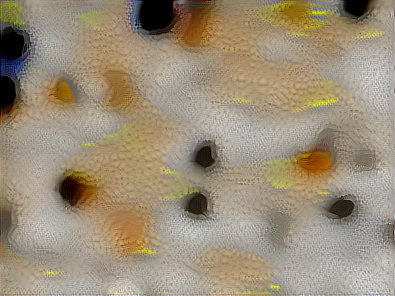

In [30]:
Image.open('/run/media/backman/yay/styleResults/res_at_iteration_9.png')

In [31]:
w,h = style.size
src = img_arr[:,:h,:w]

In [32]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [33]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [34]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [35]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [36]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.sum(metrics.mse(content_layer, content_targ))/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [37]:
evaluator = Evaluator(transfer_fn, shp)

In [38]:
iterations=10
x = rand_img(shp)

In [39]:
x = solve_image(evaluator, iterations, x)

Current loss value: 302816.59375
Current loss value: 155784.4375
Current loss value: 109309.90625
Current loss value: 86412.34375
Current loss value: 73476.328125
Current loss value: 65317.421875
Current loss value: 60204.515625
Current loss value: 56278.8671875
Current loss value: 53258.0234375
Current loss value: 51101.5234375


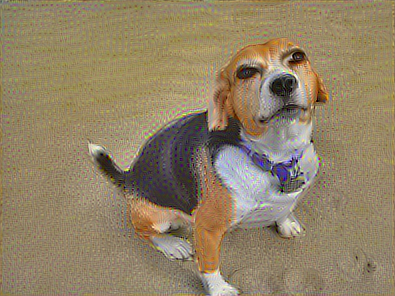

In [40]:
Image.open('/run/media/backman/yay/styleResults/res_at_iteration_9.png')